# Title of notebook

Brief 1-2 sentence description of notebook.

In [3]:
# Imports of all used packages and libraries
import os
import glob
import bisect

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from scipy.signal import butter, filtfilt, hilbert


In [4]:
import spikeinterface.extractors as se
import spikeinterface.preprocessing as sp

## Inputs & Data

Explanation of each input and where it comes from.

In [5]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc/" # where data is saved should always be shown in the inputs
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [6]:
TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 1
TIME_WINDOW_STEP = 0.5
RESAMPLE_RATE=1000
LFP_SAMPLING_RATE=1000
EPHYS_SAMPLING_RATE=20000
TRIAL_DURATION=10

In [7]:
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}

In [8]:
BASELINE_OUTCOME_TO_COLOR = {'lose': "red",
 'omission': "orange",
 'rewarded': "green",
 'win': "blue"}

In [9]:
ORDER=4
FREQ_BAND = [3, 12]
numerator_b, denominator_a = butter(ORDER, FREQ_BAND, fs=LFP_SAMPLING_RATE, btype='band')

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

# Functions

In [10]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

# Ideally functions are defined here first and then data is processed using the functions

# function names are short and in snake case all lowercase
# a function name should be unique but does not have to describe the function
# doc strings describe functions not function names

def calc_bmi(weight, height):
    """
    This is a function that calculates BMI.
    it uses height and weight...etc.
    Meghan plz show us your docsctring format here.
    """
    bmi = weight/(height**2)
    return(bmi)


In [11]:

def find_closest_nums(list1, list2):
    """
    For each number in list1, find the closest number in list2.

    Args:
    - list1 (list): An ORDERed list of numbers.
    - list2 (list): Another ORDERed list of numbers.

    Returns:
    - list: A list of closest numbers from list2 for each number in list1.
    """
    closest_nums = []

    for num in list1:
        # Find where the number would be inserted in list2
        position = bisect.bisect_left(list2, num)

        # If the number is actually present in list2, then return it
        if position != len(list2) and list2[position] == num:
            closest_nums.append(num)
        # Else find the closest of the two neighbors
        else:
            if position == 0:
                closest_nums.append(list2[0])
            elif position == len(list2):
                closest_nums.append(list2[-1])
            else:
                before = list2[position - 1]
                after = list2[position]
                closest_nums.append(before if num - before <= after - num else after)

    return closest_nums



In [12]:
def find_closest_indices(list1, list2):
    """
    For each number in list1, find the index of the closest number in list2.

    Args:
    - list1 (list): An ORDERed list of numbers.
    - list2 (list): Another ORDERed list of numbers.

    Returns:
    - list: A list of indices of the closest numbers from list2 for each number in list1.
    """
    closest_indices = []

    for num in list1:
        # Find where the number would be inserted in list2
        position = bisect.bisect_left(list2, num)

        # If the number is actually present in list2, then return its index
        if position != len(list2) and list2[position] == num:
            closest_indices.append(position)
        # Else find the index of the closest of the two neighbors
        else:
            if position == 0:
                closest_indices.append(0)
            elif position == len(list2):
                closest_indices.append(len(list2) - 1)
            else:
                before = list2[position - 1]
                after = list2[position]
                closest_indices.append(position - 1 if num - before <= after - num else position)

    return closest_indices


## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

- Getting all the timestamps of the LFPs

In [140]:
BASIC_LFP_TRACES_DF = pd.read_pickle("./proc/full_baseline_and_trial_lfp_traces.pkl")

In [141]:
BASIC_LFP_TRACES_DF = BASIC_LFP_TRACES_DF.drop_duplicates(["recording_file", "time", "current_subject"])

In [142]:
BASIC_LFP_TRACES_DF["lfp_trial_all_lfp_index"] = BASIC_LFP_TRACES_DF["lfp_index"].apply(lambda x: np.arange(x,x+TRIAL_DURATION*LFP_SAMPLING_RATE))

BASIC_LFP_TRACES_DF["lfp_baseline_all_lfp_index"] = BASIC_LFP_TRACES_DF["lfp_index"].apply(lambda x: np.arange(x-TRIAL_DURATION*LFP_SAMPLING_RATE, x))

In [143]:
BASIC_LFP_TRACES_DF["lfp_trial_all_ephys_index"] = BASIC_LFP_TRACES_DF["time_stamp_index"].apply(lambda x: np.arange(x,x+EPHYS_SAMPLING_RATE*TRIAL_DURATION, int(EPHYS_SAMPLING_RATE/LFP_SAMPLING_RATE)))

BASIC_LFP_TRACES_DF["lfp_baseline_all_ephys_index"] = BASIC_LFP_TRACES_DF["time_stamp_index"].apply(lambda x: np.arange(x-EPHYS_SAMPLING_RATE*TRIAL_DURATION, x, int(EPHYS_SAMPLING_RATE/LFP_SAMPLING_RATE)))

# Syncing LFP and spikes

In [144]:
MERGED_SPIKE_TRIAL_DF = pd.read_csv("./proc/all_spike_time.csv")

In [145]:
MERGED_SPIKE_TRIAL_DF["ephys_sample_from_trial_onset"] = MERGED_SPIKE_TRIAL_DF["spike_times"] - MERGED_SPIKE_TRIAL_DF["closest_trial"]
MERGED_SPIKE_TRIAL_DF["lfp_sample_from_trial_onset"] = MERGED_SPIKE_TRIAL_DF["ephys_sample_from_trial_onset"] // (EPHYS_SAMPLING_RATE // LFP_SAMPLING_RATE)

In [146]:
MERGED_SPIKE_TRIAL_DF = MERGED_SPIKE_TRIAL_DF[np.abs(MERGED_SPIKE_TRIAL_DF["ephys_sample_from_trial_onset"]) <= TRIAL_DURATION * EPHYS_SAMPLING_RATE].reset_index(drop=True)

In [147]:
MERGED_SPIKE_TRIAL_DF["ephys_sample_from_trial_onset"]

0        -199415
1        -199349
2        -198989
3        -198172
4        -198082
           ...  
103994    197866
103995    198511
103996    198878
103997    199693
103998    199995
Name: ephys_sample_from_trial_onset, Length: 103999, dtype: int64

In [148]:
MERGED_SPIKE_TRIAL_DF["lfp_sample_from_trial_onset"]

0        -9971
1        -9968
2        -9950
3        -9909
4        -9905
          ... 
103994    9893
103995    9925
103996    9943
103997    9984
103998    9999
Name: lfp_sample_from_trial_onset, Length: 103999, dtype: int64

In [222]:
MERGED_SPIKE_TRIAL_DF["cluster_id_with_file_name"] = MERGED_SPIKE_TRIAL_DF["cluster_id"].astype(str) + "_" + MERGED_SPIKE_TRIAL_DF["recording_name"]

# Filtering and getting the phase of all the LFPs

- Filtering all the data

In [223]:
BASIC_LFP_TRACES_DF.head()

,time,recording_dir,recording_file,time_stamp_index,video_file,video_frame,video_number,subject_info,competition_closeness,video_name,...,BLA_trial_phase,LH_baseline_filtered,LH_baseline_phase,LH_trial_filtered,LH_trial_phase,MD_baseline_filtered,MD_baseline_phase,MD_trial_filtered,MD_trial_phase,neuron_to_spike_times
0,7019726,20230619_115321_standard_comp_to_omission_D3_s...,20230619_115321_standard_comp_to_omission_D3_s...,5377470,20230619_115321_standard_comp_to_omission_D3_s...,5367,4.0,1-4_t3b3L_box2,lose_comp,20230619_115321_standard_comp_to_omission_D3_s...,...,"[2.1624116758467715, 2.4429794115230368, 2.460...","[0.5518736521451013, 0.5218667762199662, 0.489...","[-0.2492779130492871, 0.47536743457820285, 0.5...","[-0.7928298895802667, -0.8076042525557989, -0....","[2.237297797600628, 2.585778428940189, 2.60494...","[0.5295065599073167, 0.4942093334173262, 0.456...","[-0.08382839089991116, 0.625490485327475, 0.72...","[-0.9088211213321833, -0.9200910795866815, -0....","[2.2560541340773654, 2.6228178009648664, 2.641...",cluster_id lfp_samp...
1,9119725,20230619_115321_standard_comp_to_omission_D3_s...,20230619_115321_standard_comp_to_omission_D3_s...,7477469,20230619_115321_standard_comp_to_omission_D3_s...,7464,4.0,1-4_t3b3L_box2,lose_comp,20230619_115321_standard_comp_to_omission_D3_s...,...,"[2.060322631239531, 2.2535050560700562, 2.2674...","[0.0894596788592445, 0.0800010630768984, 0.070...","[-0.17777822817222358, 0.5944088710610229, 0.7...","[-0.6036158761561012, -0.6050221327556032, -0....","[2.290689411668095, 2.6902532691958223, 2.7081...","[-0.0620585346648401, -0.07200463557143977, -0...","[1.9201721172074342, 2.0423347302519077, 2.085...","[-0.7647198377732771, -0.7618630698129235, -0....","[2.319859212136162, 2.748038315849815, 2.76759...",cluster_id lfp_samp...
2,14619719,20230619_115321_standard_comp_to_omission_D3_s...,20230619_115321_standard_comp_to_omission_D3_s...,12977463,20230619_115321_standard_comp_to_omission_D3_s...,12953,4.0,1-4_t3b3L_box2,lose_comp,20230619_115321_standard_comp_to_omission_D3_s...,...,"[2.2241103763690298, 2.562095803267324, 2.5862...","[0.002838613046840373, 0.02311249078984641, 0....","[-1.5618874813949828, -1.5037791871171555, -1....","[-1.0443668114519833, -1.0345281901042884, -1....","[2.388420265423009, 2.883407682001139, 2.91533...","[-0.028720385905654806, -0.010005955928114929,...","[-1.6762282187400055, -1.6024321328576114, -1....","[-0.9331164017568173, -0.9314726625812153, -0....","[2.329885997329014, 2.770581154964947, 2.79650...",cluster_id lfp_samp...
3,15619721,20230619_115321_standard_comp_to_omission_D3_s...,20230619_115321_standard_comp_to_omission_D3_s...,13977465,20230619_115321_standard_comp_to_omission_D3_s...,13951,4.0,1-4_t3b3L_box2,lose_comp,20230619_115321_standard_comp_to_omission_D3_s...,...,"[1.7332941305000906, 1.7644665688882721, 1.782...","[-0.3482501079096777, -0.33424191279135357, -0...","[2.664540031371069, -2.9434103193155488, -2.88...","[-0.05252920733127827, -0.07528796571895098, -...","[1.6951927168159546, 1.7481568692425968, 1.792...","[-0.2730216617918332, -0.25316970011363815, -0...","[3.0915362737583427, -2.493393780527643, -2.40...","[-0.019362518109948348, -0.04171478773053513, ...","[1.6219771216037915, 1.6749639027326535, 1.725...",cluster_id lfp_samp...
4,17219723,20230619_115321_standard_comp_to_omission_D3_s...,20230619_115321_standard_comp_to_omission_D3_s...,15577467,20230619_115321_standard_comp_to_omission_D3_s...,15548,4.0,1-4_t3b3L_box2,lose_comp,20230619_115321_standard_comp_to_omission_D3_s...,...,"[2.5014090469404238, -3.1309223846765457, -3.1...","[0.4678761905286161, 0.477070690246481, 0.4863...","[-0.9468738936748807, -0.6412146645052049, -0....","[0.042177015134895676, 0.06348138037458038, 0....","[-1.1934922639820937, -0.9872988769477252, -0....","[0.38051275675979307, 0.4013796122284963, 0.42...","[-1.0694367245180432, -0.8670279040335371, -0....","[-0.21585339917948368, -0.1937750602608669, -0...","[2.5223213

In [224]:
trace_columns = [col for col in BASIC_LFP_TRACES_DF.columns if "trace" in col]

In [225]:
FREQ_BAND = [4, 12]


In [226]:
for col in trace_columns:
    region_name = "_".join(col.split("_")[:2])
    BASIC_LFP_TRACES_DF["{}_filtered".format(region_name)] = BASIC_LFP_TRACES_DF[col].apply(lambda x: filtfilt(numerator_b, denominator_a, x, padtype=None))

    BASIC_LFP_TRACES_DF["{}_phase".format(region_name)] = BASIC_LFP_TRACES_DF["{}_filtered".format(region_name)].apply(lambda x: np.angle(hilbert(x), deg=False))
    


- Plotting an example filtered trace

In [227]:
MERGED_SPIKE_TRIAL_DF.head()

,Unnamed: 0,spike_clusters,spike_times,cluster_id,1_5_ms_isi,1ms_isi,2ms_isi,amp,ch,channel_group,...,n_spikes,sh,si_unit_id,recording_name,timestamp_isi,current_isi,closest_trial,ephys_sample_from_trial_onset,lfp_sample_from_trial_onset,cluster_id_with_file_name
0,12653,64,5557899,64,4,1,12,10.794415,14,0.0,...,26442,0,9.0,20230620_114347_standard_comp_to_omission_D4_s...,5967.0,0.29835,5757314,-199415,-9971,64_20230620_114347_standard_comp_to_omission_D...
1,12654,89,5557965,89,11,11,13,17.238409,26,0.0,...,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,1820.0,0.09100,5757314,-199349,-9968,89_20230620_114347_standard_comp_to_omission_D...
2,12655,60,5558325,60,0,0,0,26.088383,5,0.0,...,11163,0,6.0,20230620_114347_standard_comp_to_omission_D4_s...,5792.0,0.28960,5757314,-198989,-9950,60_20230620_114347_standard_comp_to_omission_D...
3,12656,64,5559142,64,4,1,12,10.794415,14,0.0,...,26442,0,9.0,20230620_114347_standard_comp_to_omission_D4_s...,1243.0,0.06215,5757314,-198172,-9909,64_20230620_114347_standard_comp_to_omission_D...
4,12657,89,5559232,89,11,11,13,17.238409,26,0.0,...,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,1267.0,0.06335,5757314,-198082,-9905,89_20230620_114347_standard_comp_to_omission_D...


(0.0, 10000.0)

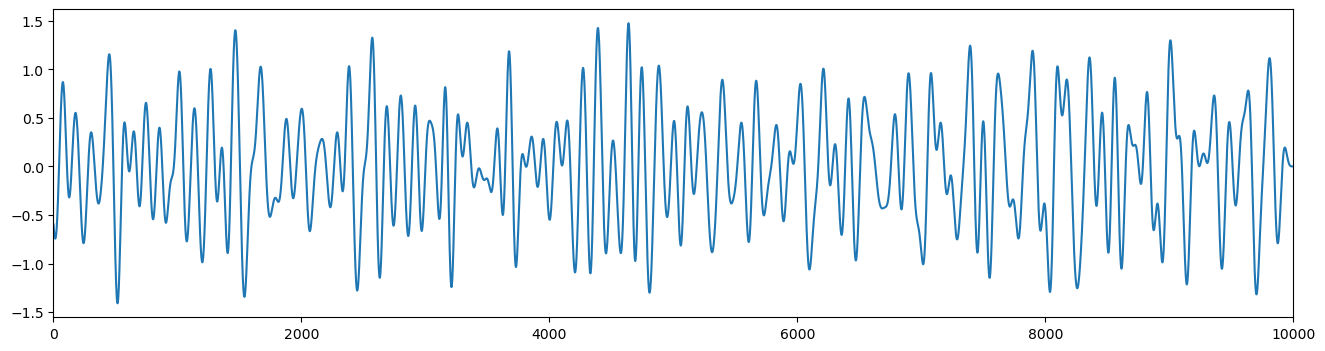

In [228]:

plt.figure(figsize=(16,4))
plt.plot(BASIC_LFP_TRACES_DF["BLA_trial_filtered"].iloc[0])

plt.xlim(0,10000)

(0.0, 10000.0)

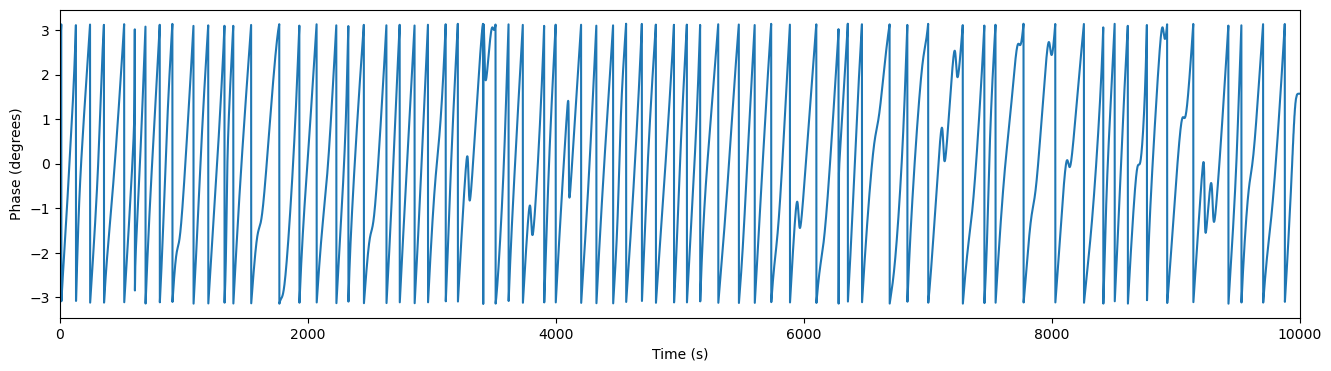

In [229]:
plt.figure(figsize=(16,4))
plt.plot(BASIC_LFP_TRACES_DF["BLA_trial_phase"].iloc[0])
plt.xlabel('Time (s)')
plt.ylabel('Phase (degrees)')

plt.xlim(0,10000)

In [230]:
BASIC_LFP_TRACES_DF

,time,recording_dir,recording_file,time_stamp_index,video_file,video_frame,video_number,subject_info,competition_closeness,video_name,...,BLA_trial_phase,LH_baseline_filtered,LH_baseline_phase,LH_trial_filtered,LH_trial_phase,MD_baseline_filtered,MD_baseline_phase,MD_trial_filtered,MD_trial_phase,neuron_to_spike_times
0,7019726,20230619_115321_standard_comp_to_omission_D3_s...,20230619_115321_standard_comp_to_omission_D3_s...,5377470,20230619_115321_standard_comp_to_omission_D3_s...,5367,4.0,1-4_t3b3L_box2,lose_comp,20230619_115321_standard_comp_to_omission_D3_s...,...,"[2.1624116758467715, 2.4429794115230368, 2.460...","[0.5518736521451013, 0.5218667762199662, 0.489...","[-0.2492779130492871, 0.47536743457820285, 0.5...","[-0.7928298895802667, -0.8076042525557989, -0....","[2.237297797600628, 2.585778428940189, 2.60494...","[0.5295065599073167, 0.4942093334173262, 0.456...","[-0.08382839089991116, 0.625490485327475, 0.72...","[-0.9088211213321833, -0.9200910795866815, -0....","[2.2560541340773654, 2.6228178009648664, 2.641...",cluster_id lfp_samp...
1,9119725,20230619_115321_standard_comp_to_omission_D3_s...,20230619_115321_standard_comp_to_omission_D3_s...,7477469,20230619_115321_standard_comp_to_omission_D3_s...,7464,4.0,1-4_t3b3L_box2,lose_comp,20230619_115321_standard_comp_to_omission_D3_s...,...,"[2.060322631239531, 2.2535050560700562, 2.2674...","[0.0894596788592445, 0.0800010630768984, 0.070...","[-0.17777822817222358, 0.5944088710610229, 0.7...","[-0.6036158761561012, -0.6050221327556032, -0....","[2.290689411668095, 2.6902532691958223, 2.7081...","[-0.0620585346648401, -0.07200463557143977, -0...","[1.9201721172074342, 2.0423347302519077, 2.085...","[-0.7647198377732771, -0.7618630698129235, -0....","[2.319859212136162, 2.748038315849815, 2.76759...",cluster_id lfp_samp...
2,14619719,20230619_115321_standard_comp_to_omission_D3_s...,20230619_115321_standard_comp_to_omission_D3_s...,12977463,20230619_115321_standard_comp_to_omission_D3_s...,12953,4.0,1-4_t3b3L_box2,lose_comp,20230619_115321_standard_comp_to_omission_D3_s...,...,"[2.2241103763690298, 2.562095803267324, 2.5862...","[0.002838613046840373, 0.02311249078984641, 0....","[-1.5618874813949828, -1.5037791871171555, -1....","[-1.0443668114519833, -1.0345281901042884, -1....","[2.388420265423009, 2.883407682001139, 2.91533...","[-0.028720385905654806, -0.010005955928114929,...","[-1.6762282187400055, -1.6024321328576114, -1....","[-0.9331164017568173, -0.9314726625812153, -0....","[2.329885997329014, 2.770581154964947, 2.79650...",cluster_id lfp_samp...
3,15619721,20230619_115321_standard_comp_to_omission_D3_s...,20230619_115321_standard_comp_to_omission_D3_s...,13977465,20230619_115321_standard_comp_to_omission_D3_s...,13951,4.0,1-4_t3b3L_box2,lose_comp,20230619_115321_standard_comp_to_omission_D3_s...,...,"[1.7332941305000906, 1.7644665688882721, 1.782...","[-0.3482501079096777, -0.33424191279135357, -0...","[2.664540031371069, -2.9434103193155488, -2.88...","[-0.05252920733127827, -0.07528796571895098, -...","[1.6951927168159546, 1.7481568692425968, 1.792...","[-0.2730216617918332, -0.25316970011363815, -0...","[3.0915362737583427, -2.493393780527643, -2.40...","[-0.019362518109948348, -0.04171478773053513, ...","[1.6219771216037915, 1.6749639027326535, 1.725...",cluster_id lfp_samp...
4,17219723,20230619_115321_standard_comp_to_omission_D3_s...,20230619_115321_standard_comp_to_omission_D3_s...,15577467,20230619_115321_standard_comp_to_omission_D3_s...,15548,4.0,1-4_t3b3L_box2,lose_comp,20230619_115321_standard_comp_to_omission_D3_s...,...,"[2.5014090469404238, -3.1309223846765457, -3.1...","[0.4678761905286161, 0.477070690246481, 0.4863...","[-0.9468738936748807, -0.6412146645052049, -0....","[0.042177015134895676, 0.06348138037458038, 0....","[-1.1934922639820937, -0.9872988769477252, -0....","[0.38051275675979307, 0.4013796122284963, 0.42...","[-1.0694367245180432, -0.8670279040335371, -0....","[-0.21585339917948368, -0.1937750602608669, -0...","[2.5223213

In [231]:
TRACE_AND_SPIKE_DF = pd.merge(left=BASIC_LFP_TRACES_DF, right=MERGED_SPIKE_TRIAL_DF, left_on=["recording_file", "time_stamp_index"], right_on=["recording_name", "closest_trial"], how="inner")

In [232]:
TRACE_AND_SPIKE_DF.columns

Index(['time', 'recording_dir', 'recording_file', 'time_stamp_index',
       'video_file', 'video_frame', 'video_number', 'subject_info',
       'competition_closeness', 'video_name', 'all_subjects',
       'current_subject', 'trial_outcome', 'lfp_index',
       'baseline_lfp_timestamp_range', 'trial_lfp_timestamp_range',
       'baseline_ephys_timestamp_range', 'trial_ephys_timestamp_range',
       'baseline_videoframe_range', 'trial_videoframe_range', 'trial_number',
       'Cohort', 'spike_interface_mPFC', 'spike_interface_vHPC',
       'spike_interface_BLA', 'spike_interface_LH', 'spike_interface_MD',
       'mPFC_baseline_lfp_trace', 'mPFC_trial_lfp_trace',
       'vHPC_baseline_lfp_trace', 'vHPC_trial_lfp_trace',
       'BLA_baseline_lfp_trace', 'BLA_trial_lfp_trace',
       'LH_baseline_lfp_trace', 'LH_trial_lfp_trace', 'MD_baseline_lfp_trace',
       'MD_trial_lfp_trace', 'lfp_trial_all_lfp_index',
       'lfp_baseline_all_lfp_index', 'lfp_trial_all_ephys_index',
       'lfp_ba

In [233]:
TRACE_AND_SPIKE_DF["mPFC_trial_phase"].iloc[0].shape

(10000,)

In [234]:
TRACE_AND_SPIKE_DF["lfp_sample_from_trial_onset"]

0        -9982
1        -9950
2        -9939
3        -9933
4        -9925
          ... 
103994    9911
103995    9956
103996    9963
103997    9972
103998    9998
Name: lfp_sample_from_trial_onset, Length: 103999, dtype: int64

In [235]:
phase_columns = [col for col in BASIC_LFP_TRACES_DF.columns if "phase" in col]

In [236]:
for col in phase_columns:
    region_name = "_".join(col.split("_")[:2])
    TRACE_AND_SPIKE_DF["{}_spike_phase".format(region_name)] = TRACE_AND_SPIKE_DF.apply(lambda x: x[col][x["lfp_sample_from_trial_onset"]], axis=1)

In [237]:
TRACE_AND_SPIKE_DF["mPFC_trial_spike_phase"]

0        -0.944314
1         0.495475
2         0.960998
3         1.213171
4         1.546641
            ...   
103994    1.714070
103995   -2.528384
103996   -2.244050
103997   -1.894557
103998   -1.570798
Name: mPFC_trial_spike_phase, Length: 103999, dtype: float64

In [238]:
outcome_df["cluster_id"].unique()

array([ 89,  64,  60,  34,  20,  85,  22,   2,  94,  90,  93,  57,  48,
       207, 153,  42, 258, 162,  43,  53, 203, 144, 259, 181, 124, 254,
       227,  58, 241,  45,  41, 251, 139, 168,  14, 221,  50, 244, 220,
       245, 226, 172])

In [240]:
TRACE_AND_SPIKE_DF["cluster_id_with_file_name"].unique()[0]

'204_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged'

In [246]:
phase_bins

array([-3.14159265, -2.7925268 , -2.44346095, -2.0943951 , -1.74532925,
       -1.3962634 , -1.04719755, -0.6981317 , -0.34906585,  0.        ,
        0.34906585,  0.6981317 ,  1.04719755,  1.3962634 ,  1.74532925,
        2.0943951 ,  2.44346095,  2.7925268 ,  3.14159265])

In [252]:
spike_phase_hist

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [274]:
from sklearn import preprocessing as pre



In [281]:
pre.MinMaxScaler().fit_transform(spike_phase_hist.reshape(-1,1)).T


array([[0.        , 0.58823529, 0.70588235, 1.        , 0.88235294,
        0.94117647, 0.76470588, 0.82352941, 0.52941176, 0.41176471,
        0.70588235, 0.64705882, 0.88235294, 0.58823529, 0.58823529,
        0.52941176, 0.41176471, 0.47058824, 0.58823529]])

[ 0. 10. 12. 17. 15. 16. 13. 14.  9.  7. 12. 11. 15. 10. 10.  9.  7.  8.
 10.]
[ 0.  8.  5. 13.  4.  9.  6.  6.  4.  7.  5.  6. 10.  9. 10. 12.  4.  7.
  4.]
[ 0. 12. 11.  7. 12. 12.  5.  4.  3.  7. 10. 10.  7.  6.  8.  7. 11.  6.
 13.]
[0. 5. 6. 2. 4. 6. 2. 5. 0. 2. 3. 4. 2. 1. 3. 2. 1. 4. 2.]


/tmp/ipykernel_306692/2659287707.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


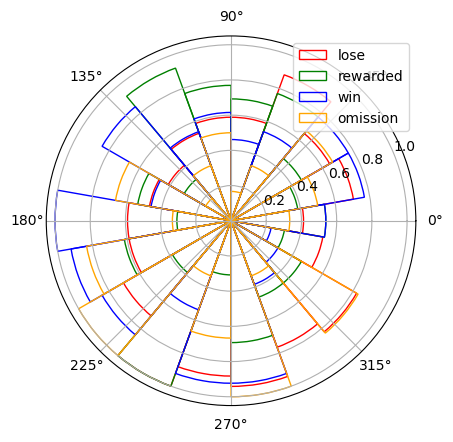

In [285]:
fig, ax = plt.subplots()

for outcome in TRACE_AND_SPIKE_DF["trial_outcome"].unique():

    outcome_df = TRACE_AND_SPIKE_DF[(TRACE_AND_SPIKE_DF["trial_outcome"] == outcome) & (TRACE_AND_SPIKE_DF["cluster_id_with_file_name"] == TRACE_AND_SPIKE_DF["cluster_id_with_file_name"].unique()[55])]
    
    spike_phases = outcome_df["mPFC_trial_spike_phase"]

    n_bins = 18
    phase_bins = np.linspace(-np.pi, np.pi, n_bins+1)
    binned_phases = np.digitize(spike_phases, phase_bins, n_bins+1)
    spike_phase_hist = np.zeros(n_bins+1)
    for bin in range(0, n_bins + 1):
        spike_phase_hist[bin] = np.sum(binned_phases == bin)
    print(spike_phase_hist)
    
    #Plot
    ax = plt.subplot(1,1,1, polar=True)
    # plt.bar(phase_bins, pre.MinMaxScaler().fit_transform(spike_phase_hist.reshape(-1,1)).T[0], width=phase_bins[1] - phase_bins[0], bottom=0.0, edgecolor=BASELINE_OUTCOME_TO_COLOR[outcome], label=outcome, color=BASELINE_OUTCOME_TO_COLOR[outcome], alpha=0.5)
    plt.bar(phase_bins, pre.MinMaxScaler().fit_transform(spike_phase_hist.reshape(-1,1)).T[0], width=phase_bins[1] - phase_bins[0], bottom=0.0, edgecolor=BASELINE_OUTCOME_TO_COLOR[outcome], label=outcome, color='none')

plt.legend()

In [272]:
spike_phase_hist

array([0., 5., 6., 2., 4., 6., 2., 5., 0., 2., 3., 4., 2., 1., 3., 2., 1.,
       4., 2.])

In [214]:
spike_phases = TRACE_AND_SPIKE_DF["mPFC_trial_spike_phase"]

[   0. 5893. 6019. 6150. 5904. 5991. 5587. 5539. 5423. 5557. 5591. 5615.
 5608. 5765. 5907. 5699. 6003. 5827. 5921.]


<BarContainer object of 19 artists>

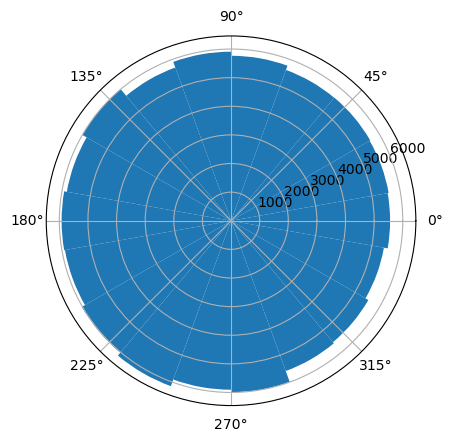

In [215]:
n_bins = 18
phase_bins = np.linspace(-np.pi, np.pi, n_bins+1)
binned_phases = np.digitize(spike_phases, phase_bins, n_bins+1)
spike_phase_hist = np.zeros(n_bins+1)
for bin in range(0, n_bins + 1):
    spike_phase_hist[bin] = np.sum(binned_phases == bin)
print(spike_phase_hist)

#Plot
ax = plt.subplot(1,1,1, polar=True)
plt.bar(phase_bins, spike_phase_hist, width=phase_bins[1] - phase_bins[0], bottom=0.0)

# OLD MERGING CODE

In [195]:
raise ValueError()

ValueError: 

In [149]:
BASIC_LFP_TRACES_DF["spike_df"] = BASIC_LFP_TRACES_DF.apply(lambda x: MERGED_SPIKE_TRIAL_DF[(MERGED_SPIKE_TRIAL_DF["recording_name"] == x["recording_file"]) & (MERGED_SPIKE_TRIAL_DF["closest_trial"] == x["time_stamp_index"])], axis=1)

In [155]:
BASIC_LFP_TRACES_DF["has_spike_df"] = BASIC_LFP_TRACES_DF["spike_df"].apply(lambda x: not x.empty)

In [156]:
BASIC_LFP_TRACES_DF = BASIC_LFP_TRACES_DF[BASIC_LFP_TRACES_DF["has_spike_df"]].reset_index(drop=True)

In [179]:
BASIC_LFP_TRACES_DF["spike_df"].iloc[0]

,Unnamed: 0,spike_clusters,spike_times,cluster_id,1_5_ms_isi,1ms_isi,2ms_isi,amp,ch,channel_group,...,group,n_spikes,sh,si_unit_id,recording_name,timestamp_isi,current_isi,closest_trial,ephys_sample_from_trial_onset,lfp_sample_from_trial_onset
81846,509822,204,5177832,204,1,0,1,11.366614,6,0.0,...,good,16516,0,17.0,20230619_115321_standard_comp_to_omission_D3_s...,1726.0,0.08630,5377470,-199638,-9982
81847,509823,134,5178486,134,5,4,17,8.562255,2,0.0,...,good,29937,0,11.0,20230619_115321_standard_comp_to_omission_D3_s...,2622.0,0.13110,5377470,-198984,-9950
81848,509824,44,5178701,44,3,1,29,9.739503,17,0.0,...,good,28280,0,46.0,20230619_115321_standard_comp_to_omission_D3_s...,3215.0,0.16075,5377470,-198769,-9939
81849,509825,134,5178825,134,5,4,17,8.562255,2,0.0,...,good,29937,0,11.0,20230619_115321_standard_comp_to_omission_D3_s...,339.0,0.01695,5377470,-198645,-9933
81850,509826,44,5178986,44,3,1,29,9.739503,17,0.0,...,good,28280,0,46.0,20230619_115321_standard_comp_to_omission_D3_s...,285.0,0.01425,5377470,-198484,-9925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83174,511150,137,5576344,137,0,0,1,14.356270,6,0.0,...,good,12504,0,17.0,20230619_115321_standard_comp_to_omission_D3_s...,351.0,0.01755,5377470,198874,9943
83175,511151,146,5576464,146,0,0,0,14.943707,6,0.0,...,good,1433,0,18.0,20230619_115321_standard_comp_to_omission_D3_s...,1031.0,0.05155,5377470,198994,9949
83176,511152,187,5576807,187,0,0,1,8.631100,14,0.0,...,good,3354,0,36.0,20230619_115321_standard_comp_to_omission_D3_s...,3089.0,0.15445,5377470,199337,9966
83177,511153,28,5576824,28,0,0,0,11.487349,12,0.0,...,good,1772,0,30.0,20230619_115321_standard_comp_to_omission_D3_s...,1853.0,0.09265,5377470,199354,9967


In [180]:
BASIC_LFP_TRACES_DF["neuron_to_spike_times"] = BASIC_LFP_TRACES_DF["spike_df"].apply(lambda x: {k: sorted(list(v)) for k, v in x.groupby("cluster_id")["lfp_sample_from_trial_onset"]})

In [187]:
BASIC_LFP_TRACES_DF["neuron_to_spike_times"] = BASIC_LFP_TRACES_DF["spike_df"].apply(lambda x: x.groupby("cluster_id")["lfp_sample_from_trial_onset"].apply(list).reset_index(name='lfp_sample_from_trial_onset'))

In [189]:
BASIC_LFP_TRACES_DF["neuron_to_spike_times"].iloc[0]

,cluster_id,lfp_sample_from_trial_onset
0,11,"[-9733, -9321, -8157, -7715, -7393, -6829, -67..."
1,28,"[-8128, 9545, 9834, 9875, 9967]"
2,44,"[-9939, -9925, -9806, -9503, -9290, -9270, -90..."
3,75,"[-8647, -7910, -6868, -6676, -6619, -6408, -55..."
4,132,"[-9354, -9294, -9236, -9082, -9015, -8959, -89..."
5,134,"[-9950, -9933, -9878, -9813, -9789, -9749, -95..."
6,137,"[-9894, -9807, -9783, -9730, -9672, -9599, -93..."
7,146,"[-408, 367, 462, 4348, 5600, 5612, 5648, 5684,..."
8,186,"[-9247, -7419, -1149, -966, 254, 1619, 2642, 3..."
9,187,"[-9826, -9585, -9466, -9376, -8215, -6295, -60..."


# Filtering and getting the phase of all the LFPs

- Filtering all the data

In [158]:
BASIC_LFP_TRACES_DF.head()

,time,recording_dir,recording_file,time_stamp_index,video_file,video_frame,video_number,subject_info,competition_closeness,video_name,...,LH_baseline_lfp_trace,LH_trial_lfp_trace,MD_baseline_lfp_trace,MD_trial_lfp_trace,lfp_trial_all_lfp_index,lfp_baseline_all_lfp_index,lfp_trial_all_ephys_index,lfp_baseline_all_ephys_index,spike_df,has_spike_df
0,7019726,20230619_115321_standard_comp_to_omission_D3_s...,20230619_115321_standard_comp_to_omission_D3_s...,5377470,20230619_115321_standard_comp_to_omission_D3_s...,5367,4.0,1-4_t3b3L_box2,lose_comp,20230619_115321_standard_comp_to_omission_D3_s...,...,"[0.9004575, 0.4485425, 0.2596825, 1.11967, 1.9...","[-0.33725, -0.4552875, -0.6036775, -0.964535, ...","[0.35191303, -0.058652174, -0.029326087, 0.876...","[-0.84068114, -1.0818068, -1.349, -1.6129348, ...","[268873, 268874, 268875, 268876, 268877, 26887...","[258873, 258874, 258875, 258876, 258877, 25887...","[5377470, 5377490, 5377510, 5377530, 5377550, ...","[5177470, 5177490, 5177510, 5177530, 5177550, ...",Unnamed: 0 spike_clusters spike_times...,True
1,9119725,20230619_115321_standard_comp_to_omission_D3_s...,20230619_115321_standard_comp_to_omission_D3_s...,7477469,20230619_115321_standard_comp_to_omission_D3_s...,7464,4.0,1-4_t3b3L_box2,lose_comp,20230619_115321_standard_comp_to_omission_D3_s...,...,"[0.7992825, 0.84987, 0.7790475, 0.7250875, 0.8...","[-0.8734775, -0.924065, -0.6745, -0.49913, -0....","[0.6745, 0.7168599, 0.57348794, 0.49854347, 0....","[-1.0101207, -1.1078744, -0.98405313, -0.76247...","[373873, 373874, 373875, 373876, 373877, 37387...","[363873, 363874, 363875, 363876, 363877, 36387...","[7477469, 7477489, 7477509, 7477529, 7477549, ...","[7277469, 7277489, 7277509, 7277529, 7277549, ...",Unnamed: 0 spike_clusters spike_times...,True
2,14619719,20230619_115321_standard_comp_to_omission_D3_s...,20230619_115321_standard_comp_to_omission_D3_s...,12977463,20230619_115321_standard_comp_to_omission_D3_s...,12953,4.0,1-4_t3b3L_box2,lose_comp,20230619_115321_standard_comp_to_omission_D3_s...,...,"[-0.047215, 0.613795, 1.1162975, 1.53786, 1.65...","[-0.6306575, -0.5766975, -0.8330075, -1.10618,...","[-0.22157487, 0.3747222, 0.8276473, 1.1241666,...","[-0.59955555, -0.62236476, -0.7950628, -0.9775...","[648873, 648874, 648875, 648876, 648877, 64887...","[638873, 638874, 638875, 638876, 638877, 63887...","[12977463, 12977483, 12977503, 12977523, 12977...","[12777463, 12777483, 12777503, 12777523, 12777...",Unnamed: 0 spike_clusters spike_times...,True
3,15619721,20230619_115321_standard_comp_to_omission_D3_s...,20230619_115321_standard_comp_to_omission_D3_s...,13977465,20230619_115321_standard_comp_to_omission_D3_s...,13951,4.0,1-4_t3b3L_box2,lose_comp,20230619_115321_standard_comp_to_omission_D3_s...,...,"[-1.6424075, -1.746955, -1.67276, -1.3119025, ...","[0.1787425, 0.1787425, 0.0775675, -0.18886, -0...","[-1.5249565, -1.5542827, -1.4272029, -1.075289...","[0.42359903, 0.5180942, 0.33887923, -0.1433719...","[698873, 698874, 698875, 698876, 698877, 69887...","[688873, 688874, 688875, 688876, 688877, 68887...","[13977465, 13977485, 13977505, 13977525, 13977...","[13777465, 13777485, 13777505, 13777525, 13777...",Unnamed: 0 spike_clusters spike_times...,True
4,17219723,20230619_115321_standard_comp_to_omission_D3_s...,20230619_115321_standard_comp_to_omission_D3_s...,15577467,20230619_115321_standard_comp_to_omission_D3_s...,15548,4.0,1-4_t3b3L_box2,lose_comp,20230619_115321_standard_comp_to_omission_D3_s...,...,"[0.7992825, 0.9443, 0.93081, 0.97128, 1.072455...","[0.4687775, 1.328765, 1.0690825, -0.2124675, -...","[0.39427295, 0.44314975, 0.49202657, 0.6712415...","[0.4627005, 1.2154034, 0.8048382, -0.45944202,...","[778873, 778874, 778875, 778876, 778877, 77887...","[768873, 768874, 768875, 768876, 768877, 76887...","[15577467, 15577487, 15577507, 15577527, 15577...","[15377467, 15377487, 15377507, 15377527, 15377...",Unnamed: 0 spike_clusters spike_times...,True


In [159]:
trace_columns = [col for col in BASIC_LFP_TRACES_DF.columns if "trace" in col]

In [160]:
FREQ_BAND = [4, 12]


In [161]:
for col in trace_columns:
    region_name = "_".join(col.split("_")[:2])
    BASIC_LFP_TRACES_DF["{}_filtered".format(region_name)] = BASIC_LFP_TRACES_DF[col].apply(lambda x: filtfilt(numerator_b, denominator_a, x, padtype=None))

    BASIC_LFP_TRACES_DF["{}_phase".format(region_name)] = BASIC_LFP_TRACES_DF["{}_filtered".format(region_name)].apply(lambda x: np.angle(hilbert(x), deg=False))
    


- Plotting an example filtered trace

In [165]:
MERGED_SPIKE_TRIAL_DF.head()

,Unnamed: 0,spike_clusters,spike_times,cluster_id,1_5_ms_isi,1ms_isi,2ms_isi,amp,ch,channel_group,...,group,n_spikes,sh,si_unit_id,recording_name,timestamp_isi,current_isi,closest_trial,ephys_sample_from_trial_onset,lfp_sample_from_trial_onset
0,12653,64,5557899,64,4,1,12,10.794415,14,0.0,...,good,26442,0,9.0,20230620_114347_standard_comp_to_omission_D4_s...,5967.0,0.29835,5757314,-199415,-9971
1,12654,89,5557965,89,11,11,13,17.238409,26,0.0,...,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,1820.0,0.09100,5757314,-199349,-9968
2,12655,60,5558325,60,0,0,0,26.088383,5,0.0,...,good,11163,0,6.0,20230620_114347_standard_comp_to_omission_D4_s...,5792.0,0.28960,5757314,-198989,-9950
3,12656,64,5559142,64,4,1,12,10.794415,14,0.0,...,good,26442,0,9.0,20230620_114347_standard_comp_to_omission_D4_s...,1243.0,0.06215,5757314,-198172,-9909
4,12657,89,5559232,89,11,11,13,17.238409,26,0.0,...,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,1267.0,0.06335,5757314,-198082,-9905


(0.0, 10000.0)

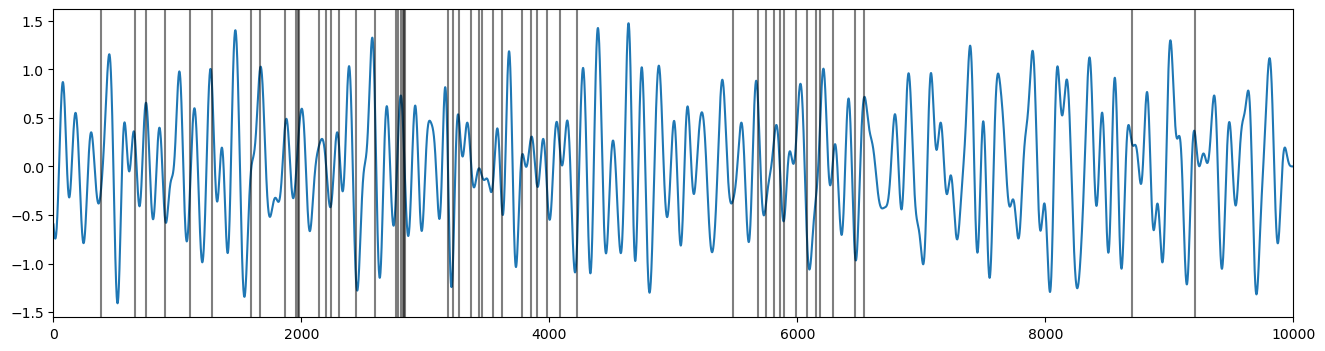

In [178]:

plt.figure(figsize=(16,4))
plt.plot(BASIC_LFP_TRACES_DF["BLA_trial_filtered"].iloc[0])

current_spike_df = BASIC_LFP_TRACES_DF["spike_df"].iloc[0]
current_unit_spikes = current_spike_df[current_spike_df["cluster_id"] == current_spike_df["cluster_id"].unique()[0]]["lfp_sample_from_trial_onset"].values

for spike in current_unit_spikes:
    plt.axvline(spike, color='black', alpha=.5)
plt.xlim(0,10000)

(0.0, 10000.0)

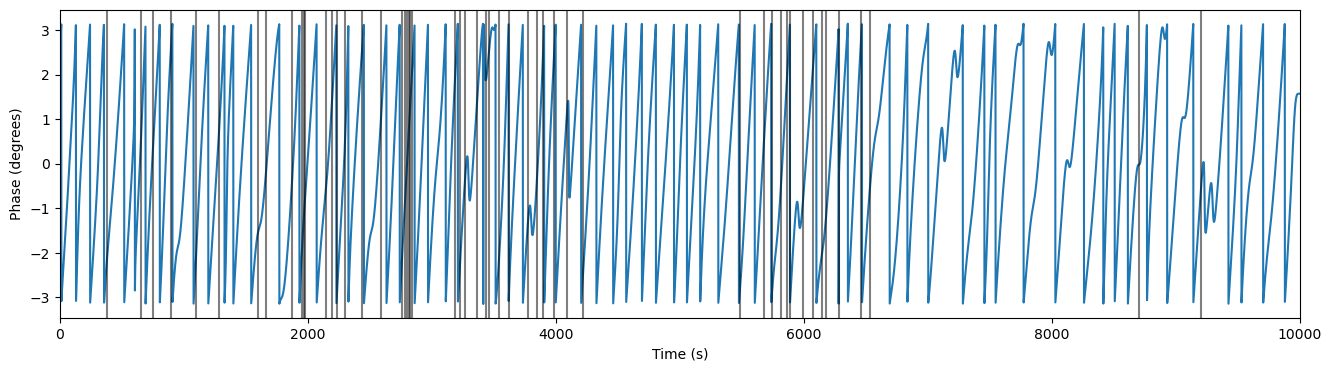

In [172]:
plt.figure(figsize=(16,4))
plt.plot(BASIC_LFP_TRACES_DF["BLA_trial_phase"].iloc[0])
plt.xlabel('Time (s)')
plt.ylabel('Phase (degrees)')
# plt.xlim(example_times[0],example_times[0] + EPHYS_SAMPLING_RATE)
for spike in current_unit_spikes:
    plt.axvline(spike, color='black', alpha=.5)
plt.xlim(0,10000)

In [39]:
BASIC_LFP_TRACES_DF.head()

,time,recording_dir,recording_file,time_stamp_index,video_file,video_frame,video_number,subject_info,competition_closeness,video_name,...,BLA_trial_filtered,BLA_trial_phase,LH_baseline_filtered,LH_baseline_phase,LH_trial_filtered,LH_trial_phase,MD_baseline_filtered,MD_baseline_phase,MD_trial_filtered,MD_trial_phase
0,6310663,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,1390826,20221202_134600_omission_and_competition_subje...,1734,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[-0.1270232139593776, -0.13550809575176323, -0...","[2.0921499379288093, 2.318664933741562, 2.3488...","[0.056868270266307065, 0.04576024370573059, 0....","[-0.8294859902205611, -0.29035528041932773, -0...","[0.1633071968546726, 0.16612519566931022, 0.16...","[-0.8714076735108721, -0.5086576686505543, -0....","[-0.20688000714736948, -0.2102295128636095, -0...","[2.4658837910421507, 2.997769183878443, 3.0297...","[-0.20527917065687415, -0.19719870709125534, -...","[2.6609099288334126, -2.9291304768028654, -2.8..."
1,7910662,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,2990825,20221202_134600_omission_and_competition_subje...,3728,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[0.06167014683416184, 0.04540589200067514, 0.0...","[1.1931051596958737, 1.364677985966047, 1.4456...","[-0.6310182399173343, -0.6028305711469237, -0....","[2.70317941107642, -2.8854240753310387, -2.816...","[0.08406742217288202, 0.054967079728184, 0.025...","[1.2979990285889775, 1.4315598190373768, 1.508...","[-0.23284599033521072, -0.19518301488393547, -...","[-2.1967190077622707, -1.9250858812347904, -1....","[0.00897178566523055, -0.02040608637520462, -0...","[1.546744032693701, 1.6197585170264568, 1.6855..."
2,9710660,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,4790823,20221202_134600_omission_and_competition_subje...,5972,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[0.09910481914715255, 0.10104307136384137, 0.1...","[-0.927968248659119, -0.5873130086540211, -0.5...","[0.1465498150487816, 0.15518114144873194, 0.16...","[-1.214160090156733, -1.1087585375109443, -1.0...","[0.1440232256165005, 0.17112191208887603, 0.19...","[-1.2734754133841686, -1.1716494030565592, -1....","[0.12243278938862083, 0.12378007869477951, 0.1...","[-1.1733709027228445, -1.053112396600152, -1.0...","[0.34646154764149273, 0.3614771084116735, 0.37...","[-0.9720995533787167, -0.682034040817512, -0.6..."
3,11310658,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,6390821,20221202_134600_omission_and_competition_subje...,7966,1.0,6_1_top_2_base_3,omission,20221202_134600_omission_and_competition_subje...,...,"[0.8079986776507001, 0.802581616330127, 0.7956...","[-0.7483757898044902, -0.25297448987131416, -0...","[-0.12212974143207109, -0.0897303594412939, -0...","[-2.0406652731308466, -1.8131783573628426, -1....","[0.881736402579422, 0.8389485366589725, 0.7945...","[-0.4412991310421433, 0.2551244873375817, 0.32...","[-0.30059619238390456, -0.26245575725812575, -...","[-2.7000185364019775, -2.1627155132289615, -2....","[0.7752331855274641, 0.7469425432890375, 0.717...","[-0.5479010625727009, 0.09808296574327503, 0.1..."
4,12810657,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,7890820,20221202_134600_omission_and_competition_subje...,9836,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[-0.254415931077215, -0.2409205597620281, -0.2...","[2.582987879734853, -3.0482235776078555, -2.99...","[-0.057397393662318, -0.04698434364269451, -0....","[-2.8402555412201433, -2.1980502765251595, -2....","[0.07969558521319708, 0.09709934263189805, 0.1...","[-1.3590004890828478, -1.292010156609553, -1.2...","[0.

In [193]:
BASIC_LFP_TRACES_DF["neuron_to_spike_times"].iloc[0]

,cluster_id,lfp_sample_from_trial_onset
0,11,"[-9733, -9321, -8157, -7715, -7393, -6829, -67..."
1,28,"[-8128, 9545, 9834, 9875, 9967]"
2,44,"[-9939, -9925, -9806, -9503, -9290, -9270, -90..."
3,75,"[-8647, -7910, -6868, -6676, -6619, -6408, -55..."
4,132,"[-9354, -9294, -9236, -9082, -9015, -8959, -89..."
5,134,"[-9950, -9933, -9878, -9813, -9789, -9749, -95..."
6,137,"[-9894, -9807, -9783, -9730, -9672, -9599, -93..."
7,146,"[-408, 367, 462, 4348, 5600, 5612, 5648, 5684,..."
8,186,"[-9247, -7419, -1149, -966, 254, 1619, 2642, 3..."
9,187,"[-9826, -9585, -9466, -9376, -8215, -6295, -60..."


In [ ]:
spike_phases = []
for spike_time in spike_times:
    spike_phases.append(phase[int(round(spike_time*fs))])

# Plotting phase and LFP

In [119]:
BASIC_LFP_TRACES_DF["spike_df"].iloc[0]

,Unnamed: 0,spike_clusters,spike_times,cluster_id,1_5_ms_isi,1ms_isi,2ms_isi,amp,ch,channel_group,...,n_spikes,sh,si_unit_id,recording_name,timestamp_isi,current_isi,closest_trial,time_from_trial_onset,ephys_sample_from_trial_onset,lfp_sample_from_trial_onset
81846,509822,204,5177832,204,1,0,1,11.366614,6,0.0,...,16516,0,17.0,20230619_115321_standard_comp_to_omission_D3_s...,1726.0,0.08630,5377470,-199638,-199638,-9982
81847,509823,134,5178486,134,5,4,17,8.562255,2,0.0,...,29937,0,11.0,20230619_115321_standard_comp_to_omission_D3_s...,2622.0,0.13110,5377470,-198984,-198984,-9950
81848,509824,44,5178701,44,3,1,29,9.739503,17,0.0,...,28280,0,46.0,20230619_115321_standard_comp_to_omission_D3_s...,3215.0,0.16075,5377470,-198769,-198769,-9939
81849,509825,134,5178825,134,5,4,17,8.562255,2,0.0,...,29937,0,11.0,20230619_115321_standard_comp_to_omission_D3_s...,339.0,0.01695,5377470,-198645,-198645,-9933
81850,509826,44,5178986,44,3,1,29,9.739503,17,0.0,...,28280,0,46.0,20230619_115321_standard_comp_to_omission_D3_s...,285.0,0.01425,5377470,-198484,-198484,-9925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83174,511150,137,5576344,137,0,0,1,14.356270,6,0.0,...,12504,0,17.0,20230619_115321_standard_comp_to_omission_D3_s...,351.0,0.01755,5377470,198874,198874,9943
83175,511151,146,5576464,146,0,0,0,14.943707,6,0.0,...,1433,0,18.0,20230619_115321_standard_comp_to_omission_D3_s...,1031.0,0.05155,5377470,198994,198994,9949
83176,511152,187,5576807,187,0,0,1,8.631100,14,0.0,...,3354,0,36.0,20230619_115321_standard_comp_to_omission_D3_s...,3089.0,0.15445,5377470,199337,199337,9966
83177,511153,28,5576824,28,0,0,0,11.487349,12,0.0,...,1772,0,30.0,20230619_115321_standard_comp_to_omission_D3_s...,1853.0,0.09265,5377470,199354,199354,9967


In [88]:
BASIC_LFP_TRACES_DF["spike_df"].iloc[5].columns

Index(['Unnamed: 0', 'spike_clusters', 'spike_times', 'cluster_id',
       '1_5_ms_isi', '1ms_isi', '2ms_isi', 'amp', 'ch', 'channel_group',
       'depth', 'fr', 'group', 'n_spikes', 'sh', 'si_unit_id',
       'recording_name', 'timestamp_isi', 'current_isi', 'closest_trial'],
      dtype='object')

In [87]:
BASIC_LFP_TRACES_DF.columns

Index(['time', 'recording_dir', 'recording_file', 'time_stamp_index',
       'video_file', 'video_frame', 'video_number', 'subject_info',
       'competition_closeness', 'video_name', 'all_subjects',
       'current_subject', 'trial_outcome', 'lfp_index',
       'baseline_lfp_timestamp_range', 'trial_lfp_timestamp_range',
       'baseline_ephys_timestamp_range', 'trial_ephys_timestamp_range',
       'baseline_videoframe_range', 'trial_videoframe_range', 'trial_number',
       'Cohort', 'spike_interface_mPFC', 'spike_interface_vHPC',
       'spike_interface_BLA', 'spike_interface_LH', 'spike_interface_MD',
       'mPFC_baseline_lfp_trace', 'mPFC_trial_lfp_trace',
       'vHPC_baseline_lfp_trace', 'vHPC_trial_lfp_trace',
       'BLA_baseline_lfp_trace', 'BLA_trial_lfp_trace',
       'LH_baseline_lfp_trace', 'LH_trial_lfp_trace', 'MD_baseline_lfp_trace',
       'MD_trial_lfp_trace', 'lfp_trial_all_lfp_index',
       'lfp_baseline_all_lfp_index', 'lfp_trial_all_ephys_index',
       'lfp_ba

In [45]:
rec_file = MERGED_SPIKE_TRIAL_DF["recording_name"].unique()[0]

In [46]:
example_trial = BASIC_LFP_TRACES_DF[BASIC_LFP_TRACES_DF["recording_file"] == rec_file].iloc[15]

In [47]:
example_trial.index

Index(['time', 'recording_dir', 'recording_file', 'time_stamp_index',
       'video_file', 'video_frame', 'video_number', 'subject_info',
       'competition_closeness', 'video_name', 'all_subjects',
       'current_subject', 'trial_outcome', 'lfp_index',
       'baseline_lfp_timestamp_range', 'trial_lfp_timestamp_range',
       'baseline_ephys_timestamp_range', 'trial_ephys_timestamp_range',
       'baseline_videoframe_range', 'trial_videoframe_range', 'trial_number',
       'Cohort', 'spike_interface_mPFC', 'spike_interface_vHPC',
       'spike_interface_BLA', 'spike_interface_LH', 'spike_interface_MD',
       'mPFC_baseline_lfp_trace', 'mPFC_trial_lfp_trace',
       'vHPC_baseline_lfp_trace', 'vHPC_trial_lfp_trace',
       'BLA_baseline_lfp_trace', 'BLA_trial_lfp_trace',
       'LH_baseline_lfp_trace', 'LH_trial_lfp_trace', 'MD_baseline_lfp_trace',
       'MD_trial_lfp_trace', 'lfp_trial_all_lfp_index',
       'lfp_baseline_all_lfp_index', 'lfp_trial_all_ephys_index',
       'lfp_ba

In [48]:
example_start, example_end = example_trial["trial_ephys_timestamp_range"]

In [49]:
example_spike_df = MERGED_SPIKE_TRIAL_DF[MERGED_SPIKE_TRIAL_DF["recording_name"] == rec_file]

In [50]:
example_spike_df = example_spike_df[(example_spike_df["spike_times"] > example_start) & (example_spike_df["spike_times"] < example_end)]

In [57]:
example_spike_df[["spike_clusters", "spike_times"]]

,spike_clusters,spike_times
58068,64,29858392
58069,89,29858818
58070,89,29860378
58071,64,29860572
58072,89,29860625
...,...,...
58617,60,30056342
58618,89,30056437
58619,60,30056651
58620,89,30057493


In [56]:
example_spike_df

,Unnamed: 0,spike_clusters,spike_times,cluster_id,1_5_ms_isi,1ms_isi,2ms_isi,amp,ch,channel_group,depth,fr,group,n_spikes,sh,si_unit_id,recording_name,timestamp_isi,current_isi,closest_trial
58068,58068,64,29858392,64,4,1,12,10.794415,14,0.0,280.0,7.735803,good,26442,0,9.0,20230620_114347_standard_comp_to_omission_D4_s...,2849.0,0.14245,29857611
58069,58069,89,29858818,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,2806.0,0.14030,29857611
58070,58070,89,29860378,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,1560.0,0.07800,29857611
58071,58071,64,29860572,64,4,1,12,10.794415,14,0.0,280.0,7.735803,good,26442,0,9.0,20230620_114347_standard_comp_to_omission_D4_s...,2180.0,0.10900,29857611
58072,58072,89,29860625,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,247.0,0.01235,29857611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58617,58617,60,30056342,60,0,0,0,26.088383,5,0.0,100.0,3.265818,good,11163,0,6.0,20230620_114347_standard_comp_to_omission_D4_s...,1587.0,0.07935,29857611
58618,58618,89,30056437,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,749.0,0.03745,29857611
58619,58619,60,30056651,60,0,0,0,26.088383,5,0.0,100.0,3.265818,good,11163,0,6.0,20230620_114347_standard_comp_to_omission_D4_s...,309.0,0.01545,29857611
58620,58620,89,30057493,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,1056.0,0.05280,29857611


In [61]:
merged_df = pd.merge(left=BASIC_LFP_TRACES_DF, right=MERGED_SPIKE_TRIAL_DF, left_on=["recording_file", "time_stamp_index"], right_on=["recording_name", "closest_trial"], how="inner")

In [65]:
merged_df.columns

Index(['time', 'recording_dir', 'recording_file', 'time_stamp_index',
       'video_file', 'video_frame', 'video_number', 'subject_info',
       'competition_closeness', 'video_name', 'all_subjects',
       'current_subject', 'trial_outcome', 'lfp_index',
       'baseline_lfp_timestamp_range', 'trial_lfp_timestamp_range',
       'baseline_ephys_timestamp_range', 'trial_ephys_timestamp_range',
       'baseline_videoframe_range', 'trial_videoframe_range', 'trial_number',
       'Cohort', 'spike_interface_mPFC', 'spike_interface_vHPC',
       'spike_interface_BLA', 'spike_interface_LH', 'spike_interface_MD',
       'mPFC_baseline_lfp_trace', 'mPFC_trial_lfp_trace',
       'vHPC_baseline_lfp_trace', 'vHPC_trial_lfp_trace',
       'BLA_baseline_lfp_trace', 'BLA_trial_lfp_trace',
       'LH_baseline_lfp_trace', 'LH_trial_lfp_trace', 'MD_baseline_lfp_trace',
       'MD_trial_lfp_trace', 'lfp_trial_all_lfp_index',
       'lfp_baseline_all_lfp_index', 'lfp_trial_all_ephys_index',
       'lfp_ba

In [58]:
BASIC_LFP_TRACES_DF

,time,recording_dir,recording_file,time_stamp_index,video_file,video_frame,video_number,subject_info,competition_closeness,video_name,...,BLA_trial_filtered,BLA_trial_phase,LH_baseline_filtered,LH_baseline_phase,LH_trial_filtered,LH_trial_phase,MD_baseline_filtered,MD_baseline_phase,MD_trial_filtered,MD_trial_phase
0,6310663,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,1390826,20221202_134600_omission_and_competition_subje...,1734,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[-0.1270232139593776, -0.13550809575176323, -0...","[2.0921499379288093, 2.318664933741562, 2.3488...","[0.056868270266307065, 0.04576024370573059, 0....","[-0.8294859902205611, -0.29035528041932773, -0...","[0.1633071968546726, 0.16612519566931022, 0.16...","[-0.8714076735108721, -0.5086576686505543, -0....","[-0.20688000714736948, -0.2102295128636095, -0...","[2.4658837910421507, 2.997769183878443, 3.0297...","[-0.20527917065687415, -0.19719870709125534, -...","[2.6609099288334126, -2.9291304768028654, -2.8..."
1,7910662,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,2990825,20221202_134600_omission_and_competition_subje...,3728,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[0.06167014683416184, 0.04540589200067514, 0.0...","[1.1931051596958737, 1.364677985966047, 1.4456...","[-0.6310182399173343, -0.6028305711469237, -0....","[2.70317941107642, -2.8854240753310387, -2.816...","[0.08406742217288202, 0.054967079728184, 0.025...","[1.2979990285889775, 1.4315598190373768, 1.508...","[-0.23284599033521072, -0.19518301488393547, -...","[-2.1967190077622707, -1.9250858812347904, -1....","[0.00897178566523055, -0.02040608637520462, -0...","[1.546744032693701, 1.6197585170264568, 1.6855..."
2,9710660,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,4790823,20221202_134600_omission_and_competition_subje...,5972,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[0.09910481914715255, 0.10104307136384137, 0.1...","[-0.927968248659119, -0.5873130086540211, -0.5...","[0.1465498150487816, 0.15518114144873194, 0.16...","[-1.214160090156733, -1.1087585375109443, -1.0...","[0.1440232256165005, 0.17112191208887603, 0.19...","[-1.2734754133841686, -1.1716494030565592, -1....","[0.12243278938862083, 0.12378007869477951, 0.1...","[-1.1733709027228445, -1.053112396600152, -1.0...","[0.34646154764149273, 0.3614771084116735, 0.37...","[-0.9720995533787167, -0.682034040817512, -0.6..."
3,11310658,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,6390821,20221202_134600_omission_and_competition_subje...,7966,1.0,6_1_top_2_base_3,omission,20221202_134600_omission_and_competition_subje...,...,"[0.8079986776507001, 0.802581616330127, 0.7956...","[-0.7483757898044902, -0.25297448987131416, -0...","[-0.12212974143207109, -0.0897303594412939, -0...","[-2.0406652731308466, -1.8131783573628426, -1....","[0.881736402579422, 0.8389485366589725, 0.7945...","[-0.4412991310421433, 0.2551244873375817, 0.32...","[-0.30059619238390456, -0.26245575725812575, -...","[-2.7000185364019775, -2.1627155132289615, -2....","[0.7752331855274641, 0.7469425432890375, 0.717...","[-0.5479010625727009, 0.09808296574327503, 0.1..."
4,12810657,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,7890820,20221202_134600_omission_and_competition_subje...,9836,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[-0.254415931077215, -0.2409205597620281, -0.2...","[2.582987879734853, -3.0482235776078555, -2.99...","[-0.057397393662318, -0.04698434364269451, -0....","[-2.8402555412201433, -2.1980502765251595, -2....","[0.07969558521319708, 0.09709934263189805, 0.1...","[-1.3590004890828478, -1.292010156609553, -1.2...","[0.

In [27]:
# Group by 'Group' column and get group sizes
group_sizes = example_spike_df.groupby('cluster_id').size()

# Identify the group with the largest count
group_with_max_count = group_sizes.idxmax()
print(f"The group with the largest count is: {group_with_max_count}")

# If you also want to retrieve the actual rows of that group:
max_group_data = example_spike_df[example_spike_df['cluster_id'] == group_with_max_count]["spike_times"]


The group with the largest count is: 89


In [28]:
example_times = example_trial["lfp_trial_all_ephys_index"]

In [29]:
example_trace = example_trial["mPFC_baseline_lfp_trace"]

In [30]:
aligned_spike_times = find_closest_nums(max_group_data, example_trial["lfp_trial_all_ephys_index"])

(29857611.0, 29877611.0)

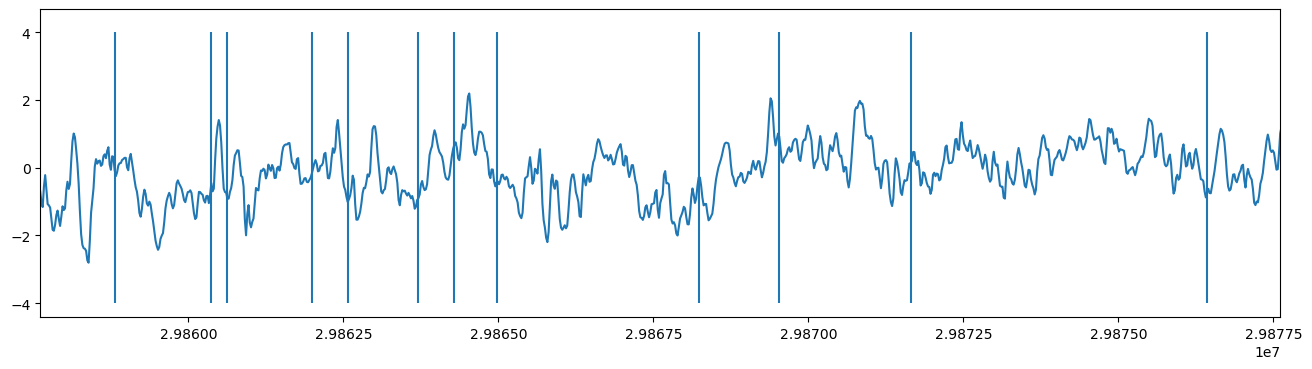

In [31]:
plt.figure(figsize=(16,4))
plt.plot(example_times, example_trace)
for time_stamp in aligned_spike_times:
    plt.vlines(x=time_stamp, ymin=-4, ymax=4)
plt.xlim(example_times[0],example_times[0] + EPHYS_SAMPLING_RATE)

(29857611.0, 29877611.0)

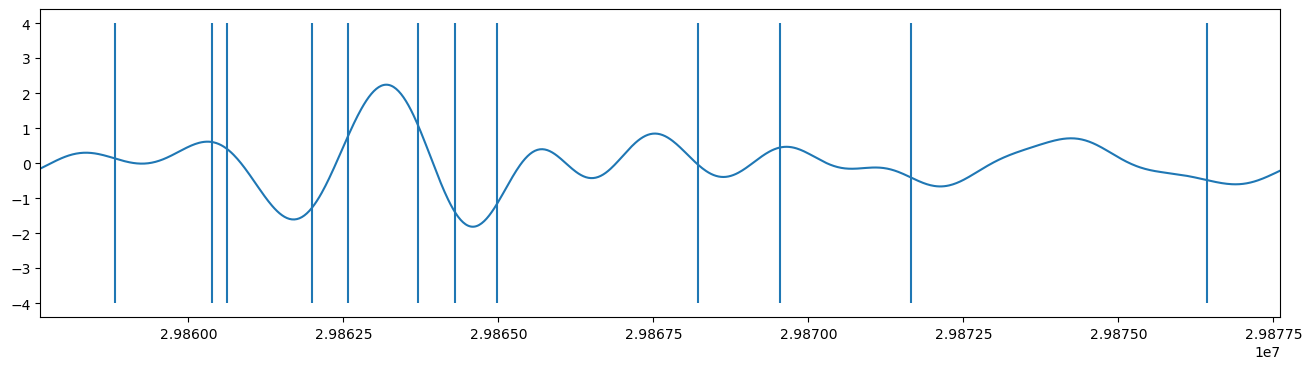

In [32]:
plt.figure(figsize=(16,4))
plt.plot(example_times, example_trial["mPFC_trial_filtered"])
for time_stamp in max_group_data:
    plt.vlines(x=time_stamp, ymin=-4, ymax=4)
plt.xlim(example_times[0],example_times[0] + EPHYS_SAMPLING_RATE)

(29857611.0, 29877611.0)

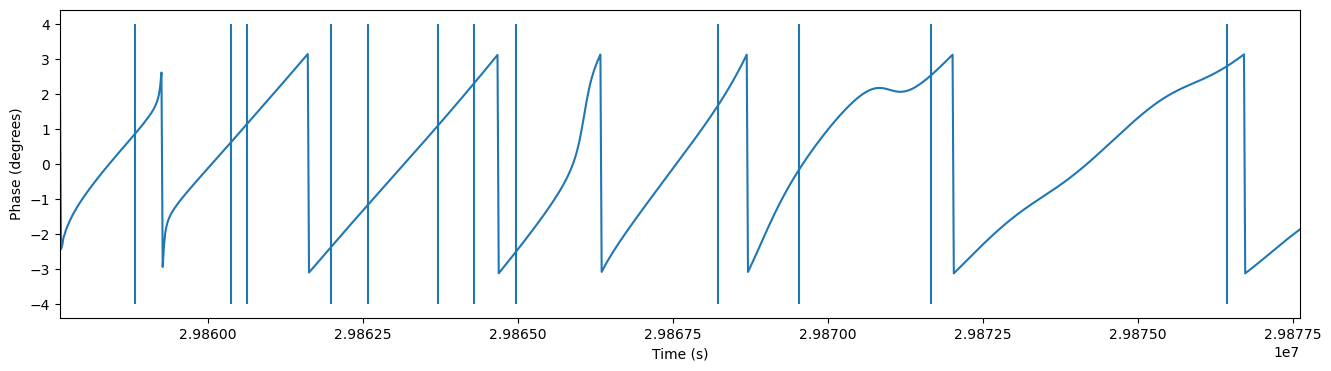

In [33]:
plt.figure(figsize=(16,4))
plt.plot(example_times, example_trial["mPFC_trial_phase"])
plt.xlabel('Time (s)')
plt.ylabel('Phase (degrees)')
for time_stamp in max_group_data:
    plt.vlines(x=time_stamp, ymin=-4, ymax=4)
plt.xlim(example_times[0],example_times[0] + EPHYS_SAMPLING_RATE)

In [34]:
aligned_spike_indices = find_closest_indices(max_group_data, example_times)

In [35]:
spike_phases = []
for spike_time in aligned_spike_indices:
    spike_phases.append(example_trial["mPFC_trial_phase"][spike_time])


[ 0. 15. 12. 11. 11.  9. 13.  9.  7.  8. 12. 11. 13. 23. 14. 11. 12. 16.
  5.]


<BarContainer object of 19 artists>

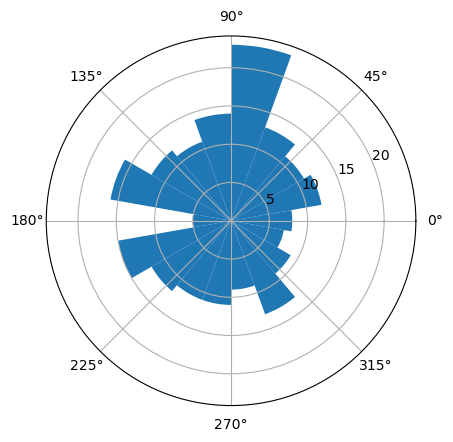

In [36]:
n_bins = 18
phase_bins = np.linspace(-np.pi, np.pi, n_bins+1)
binned_phases = np.digitize(spike_phases, phase_bins, n_bins+1)
spike_phase_hist = np.zeros(n_bins+1)
for bin in range(0, n_bins + 1):
    spike_phase_hist[bin] = np.sum(binned_phases == bin)
print(spike_phase_hist)

#Plot
ax = plt.subplot(1,1,1, polar=True)
plt.bar(phase_bins, spike_phase_hist, width=phase_bins[1] - phase_bins[0], bottom=0.0)